# Test the one-line CLEDB inversion on synthetic CLE data.

In [1]:
## the script version "test_1line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

<Figure size 1080x1080 with 0 Axes>

In [2]:
## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 bservation arrays

## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams 
params=ctrlparams.ctrlparams()    ## just a shorter label

### 1. LOAD the input data

In [3]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
    sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
sobsa=sobsa[:,:,::-1,:]

## A fake minimal header for CLE
## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun. The wavelength raferences (vacuum), ranges and spectral resolutions are unique. See CLE outfiles and grid.dat.
head_in =  [np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
                     -0.75, 0.8, 1074.62686-0.0124,\
                     (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0247,"CLE-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
            np.array((0, 0, np.int32(sobsa.shape[2]/2)-1,\
                     -0.75, 0.8, 1079.78047-0.0124,\
                     (0.75-(-0.75))/sobsa.shape[0], (1.5-0.8)/sobsa.shape[1], 0.0249,"CLE-SIM" ),\
                    dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
                              ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
                              ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume', 'U7')]).view(np.recarray)  ]


#waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
#waveB=waveB[::-1]

In [4]:
## load the fake observation muram data.
## FE XIII 1074+1079

# with open('obsstokes_avg_muram3.pkl','rb') as f:
#     sobsa = pickle.load(f) 
# sobsa=sobsa[0]    ##needed because sobsa was saved as a 1 element list instead of pure np.array;

## A fake minimal header for MURAM
## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun (from muram xvec and yvec arrays). The wavelength raferences (vacuum), ranges and spectral resolutions are unique (muram wvvec1 and wvvce2 arrays).
# head_in =  [np.array((0, 0, 0,\
#                      -0.071, 0.989, 1074.257137,\
#                      0.0001379,  0.0000689, 0.0071641,"MUR-SIM" ),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray),\
#             np.array((0, 0, 0,\
#                     -0.071, 0.989, 1079.420513,\
#                      0.0001379,  0.0000689, 0.0071985,"MUR-SIM" ),\
#                     dtype = [('crpix1', np.float32), ('crpix2', np.float32), ('crpix3', np.float32),\
#                               ('crval1', np.float32), ('crval2', np.float32),('crval3', np.float32),\
#                               ('cdelt1', np.float32), ('cdelt2', np.float32),('cdelt3', np.float32), ('instrume','U7')]).view(np.recarray)  ]


## muram data too big to include as test data!!!!

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [5]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [6]:
## take in just one line from the observation; e.g. one set of IQUV

## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4]]                   ## standard python lists will be deprecated by numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None]

##### preprocess the observation "files"

In [7]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,head_in,params)

------------------------------------
--------OBS PROCESSING START--------
------------------------------------
We are inverting observations of 1 coronal line(s) 
Line 1: Fe XIII 1074.7nm
------------------------------------
-----OBS PREPROCESS FINALIZED-------
------------------------------------


##### At this point all necesary data is loaded into memory; 
##### An analythical LOS B field solution is used and the database is not required in this case

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [8]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [48]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)    ## when storing to disk do an if to reduce dimensions for 1 line cases

--------------------------------------
SPECTRO_PROC: SPECTROSCOPY START
--------------------------------------
SPECTRO_PROC: Executing ext. loop: 0  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 1  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 2  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 3  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 4  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 5  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 6  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 7  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 8  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 9  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 10  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 11  of  600  ( 280  calculat

##### Process the LOS vector magnetic field inversion products (Analythical solution)

In [55]:
importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)

--------------------------------------
--BLOS_PROC: LOS B ESTIMATION START--
--------------------------------------


<ipython-input-55-9d66df0eb8c1>:2: RuntimeWarning: invalid value encountered in double_scalars
  blosout=procinv.blos_proc(sobs_tot,rms,keyvals,consts,params)


--------------------------------------
---BLOS_PROC: LOS B ESTIMATION END----
--------------------------------------


## All should be good if we reached this point; all the outputs should be computed and saved in memory.

## 4. OPTIONAL tidbits

In [50]:
##optionally needed libraries and functions

from datetime import datetime
import os
import glob
import numpy as np

from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if widget is installed
%matplotlib widget 
       

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.2f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar


### 4.a DUMP results (optional)

In [51]:
## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_1line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])
        
## save the last run       
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")     

if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')

with open(f'./testrun_outputs/outparams_1line_{datestamp}.pkl', 'wb') as f:  
    pickle.dump([specout,blosout], f)

### 4.b PLOT the outputs (optional)

In [52]:
## Plot utils
import numpy as np
linen=0                ## choose which line to plot; range is [0:1] for 2 line input

## plot subranges for soome in snapshots
# ## 3dipole
srx1=230
srx2=400
sry1=65
sry2=195
rnge=[0.8,1.5,-1.1,1.1]

##muram      ## muram data not offered as part of the test scripts due to large sizes.
# srx1=0
# srx2=1023
# sry1=0
# sry2=1023
# rnge=[0.989,1.060,-0.071,0.071]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
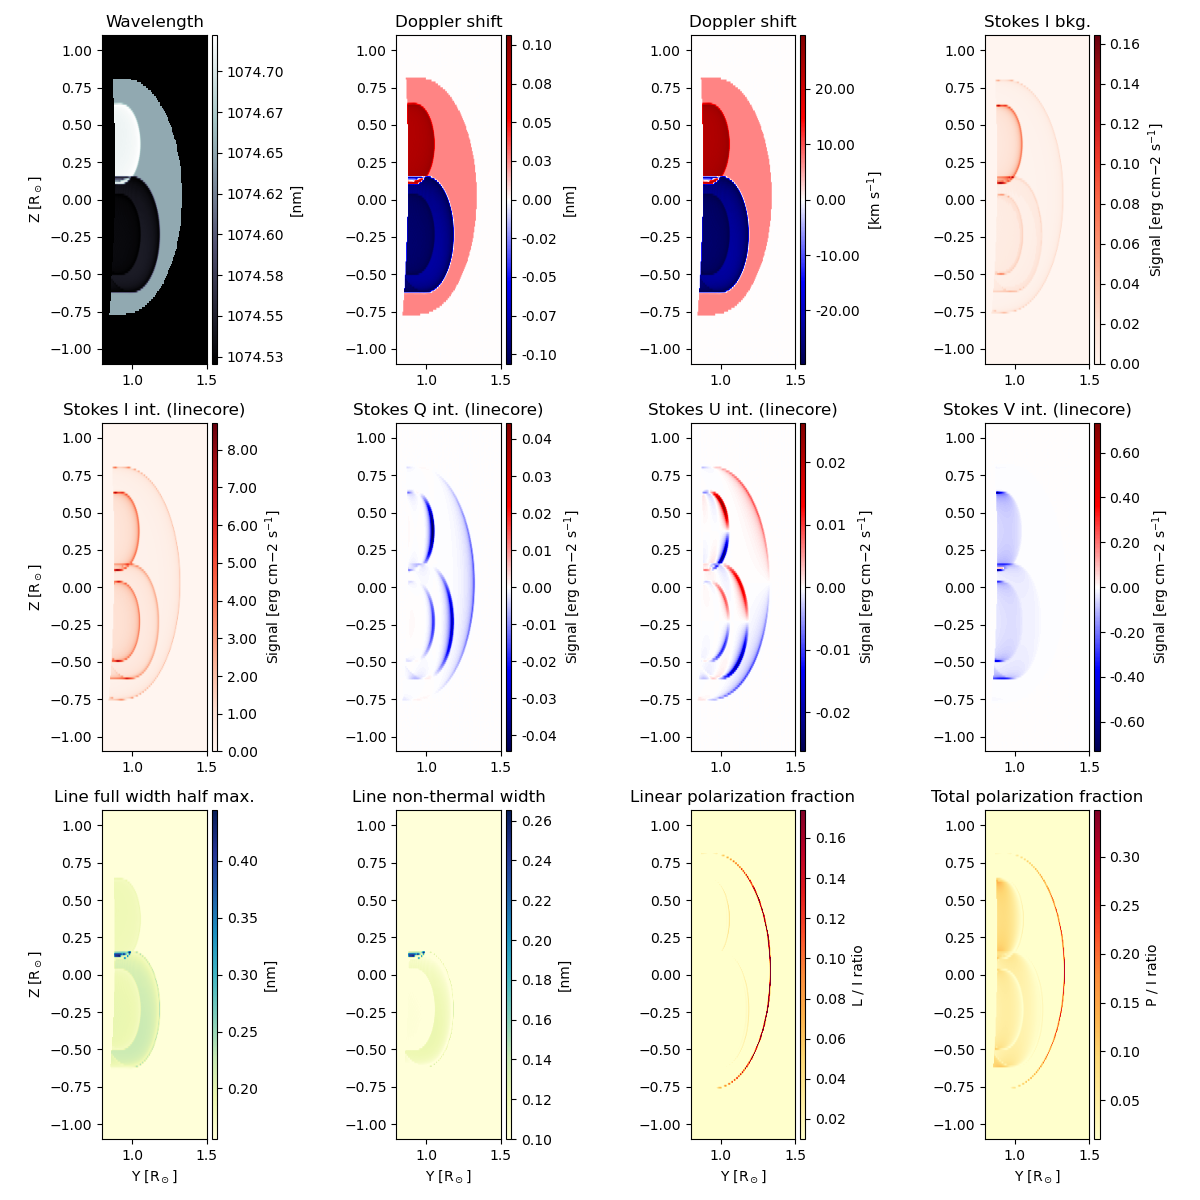

In [53]:
##Plot spectroscopy

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,12))

## remove the 0 values and unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='bone')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting    
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################

ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds')
plots[1,0].set_title('Stokes I int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,1].set_title('Stokes Q int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,2].set_title('Stokes U int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,6])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,6])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,3].set_title('Stokes V int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8]>= 0.45 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,8]<= 0.01 )
vvmax=np.max(mx)
vvmin=np.min(mx)

ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='YlGnBu')
plots[2,0].set_title('Line full width half max.')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS TO SHOW THAT THEY ARE FRACTIONS.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9]>= 0.35 )
vvmax=np.nanmax(mx)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,9]<= 0.01 )
vvmin=np.nanmin(mx)

ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,vmin=0.1,vmax=vvmax,cmap='YlGnBu')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,vmin=0.01,vmax=0.5*np.max(specout[srx1:srx2,sry1:sry2,linen,10]),cmap='YlOrRd')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,vmin=0.01,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,11]),cmap='YlOrRd')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/specout_1line_sol{linen}_{datestamp}.pdf")

<ipython-input-57-08368f7d273d>:33: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")
/home/noxpara/anaconda3/envs/CLEDBenv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:306: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  self.figure.savefig(buf, format='png', dpi='figure')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
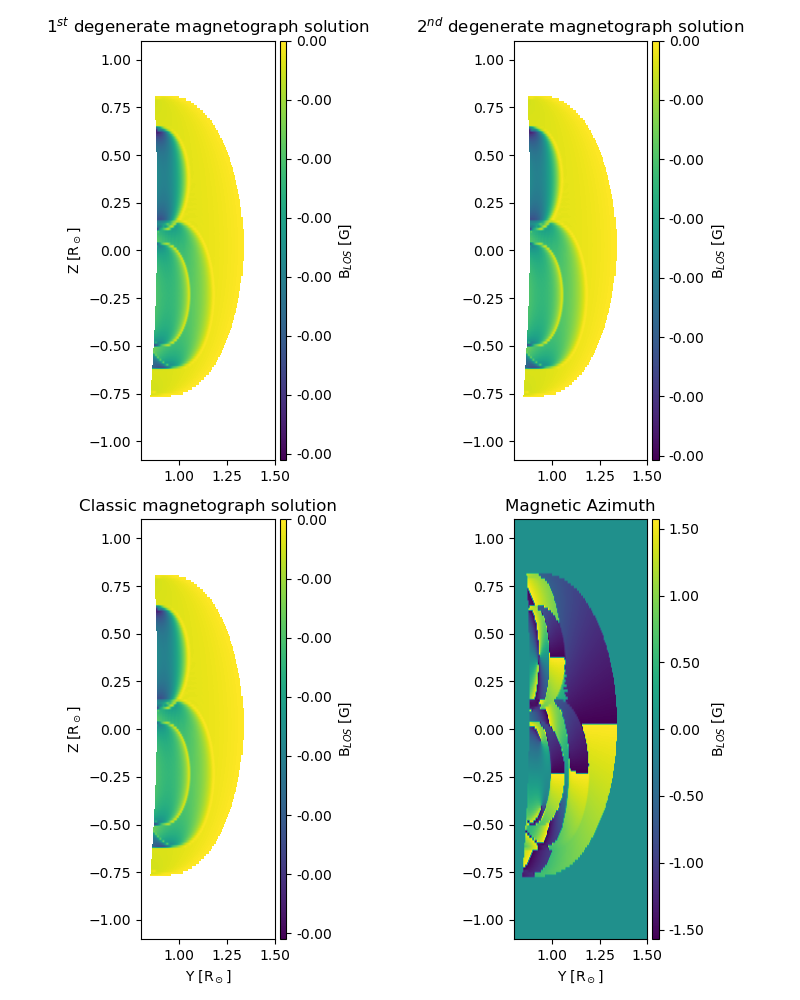

In [57]:
## plot 1-line BLOS


fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,10))
ab=plots[0,0].imshow(blosout[srx1:srx2,sry1:sry2,0],extent=rnge)
plots[0,0].set_title('1$^{st}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')

ab=plots[0,1].imshow(blosout[srx1:srx2,sry1:sry2,1],extent=rnge)
plots[0,1].set_title('2$^{nd}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')

ab=plots[1,0].imshow(blosout[srx1:srx2,sry1:sry2,2],extent=rnge)
plots[1,0].set_title('Classic magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')

ab=plots[1,1].imshow(blosout[srx1:srx2,sry1:sry2,3],extent=rnge)
plots[1,1].set_title('Magnetic Azimuth')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,1].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")